# [PACKUS] 고객등급 재개편

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc, rcParams
import matplotlib.ticker as ticker

In [2]:
def set_korea_font():
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    rcParams.update({'font.size': 11})
    rcParams['axes.unicode_minus'] = False  
set_korea_font()

### 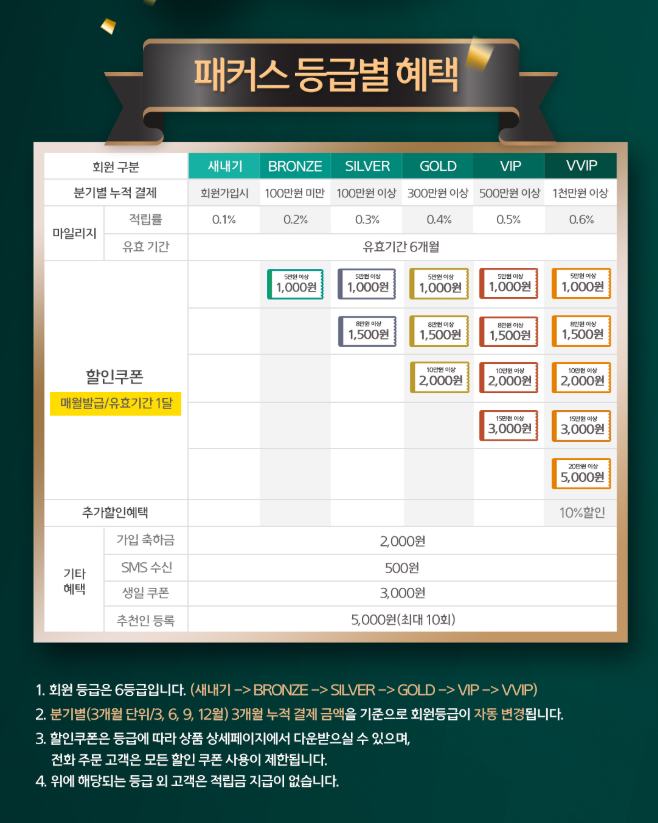

In [3]:
data = pd.read_excel('(통합)고객 주문리스트17-19.xlsx')

## 2019.01.01~ 2019.03.31

### 1) id에서 '@' 제거하기

In [4]:
data['결제일시(입금확인일)'] = pd.to_datetime(data['결제일시(입금확인일)']).dt.to_period('D')
data = data.set_index(data['결제일시(입금확인일)'])

In [5]:
# 1월 ~ 3월
janmar = data[(data.index.year==2019)&(data.index.month<4)]
janmar = janmar.dropna(subset=['주문자ID'])

In [6]:
janmar1 = janmar.loc[janmar['주문자ID'].str.contains("@",na=False)]
janmar2 = janmar.loc[(janmar['주문자ID'].str.contains("@",na=False))==False]
janmar1['주문자ID'] = janmar1['주문자ID'].str.extract(r'(\w+)@').dropna()

In [7]:
janmar = pd.concat([janmar1, janmar2])

In [8]:
janmar.shape

(9381, 110)

## (2019.1분기 구매자 2166 중) 
>### 2번 이상 구매한 사람 995명의 구매 주기 평균은?
> "가장 최근 구매한 2건의 날짜 차이"를 995명 평균내기

In [9]:
timeinterval = janmar[['주문자ID','결제일시(입금확인일)']]

In [10]:
timeinterval.head()

,주문자ID,결제일시(입금확인일)
결제일시(입금확인일),,
2019-01-01,23533593,2019-01-01
2019-01-02,908029973,2019-01-02
2019-01-02,40648393,2019-01-02
2019-01-02,152269897,2019-01-02
2019-01-01,31739713,2019-01-01


In [11]:
timeinterval = timeinterval.drop_duplicates(subset=['주문자ID','결제일시(입금확인일)'])

In [12]:
# 주문이 2건 이상 되는 사람들
people2up = timeinterval.groupby('주문자ID').count()>1

In [13]:
id2up = people2up[people2up['결제일시(입금확인일)']==1].index
print('2019.1분기 전체 고객 수 :',janmar['주문자ID'].nunique())
print('2019.1분기 2건 이상 구매 고객 수 :',len(id2up))

2019.1분기 전체 고객 수 : 2166
2019.1분기 2건 이상 구매 고객 수 : 995


In [14]:
twodates_per_people = timeinterval[timeinterval['주문자ID'].isin(id2up)].groupby('주문자ID').tail(2).sort_values(by=['주문자ID'])

In [15]:
twodates_per_people.head()

,주문자ID,결제일시(입금확인일)
결제일시(입금확인일),,
2019-03-27,1003409866,2019-03-27
2019-03-19,1003409866,2019-03-19
2019-01-15,1008831959,2019-01-15
2019-03-11,1008831959,2019-03-11
2019-03-18,1009216553,2019-03-18


In [16]:
onedate1_per_people = twodates_per_people[0::2]
onedate2_per_people = twodates_per_people[1::2]

In [17]:
twodatediff = abs(onedate1_per_people['결제일시(입금확인일)'].values - onedate2_per_people['결제일시(입금확인일)'].values)

Text(0.5, 1.0, '구매주기 차이')

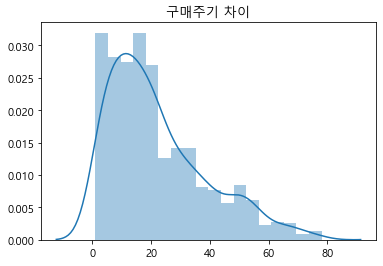

In [18]:
#set_korea_font()
sns.distplot(twodatediff).set_title('구매주기 차이')

Text(0.5, 1.0, '구매주기 차이')

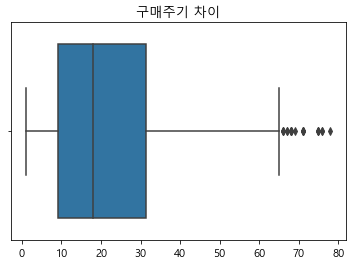

In [19]:
sns.boxplot(twodatediff).set_title('구매주기 차이')

In [20]:
from scipy import stats
stats.describe(twodatediff)

DescribeResult(nobs=995, minmax=(1, 78), mean=22.128643216080402, variance=281.18262944501197, skewness=0.9959074138166149, kurtosis=0.3633575802026927)

### 산업 특성 상, 한달(22일)에 한번 구매한다고 볼 수 있음.
>### 고객 등급의 변동의 안정성을 위해, 현재의 기준 그대로 1분기(3달)은 이상할 것이 없어 보임.
>### 그렇다면, 금액 조절을 통해 등급의 변동성을 조정하면 좋을 듯!

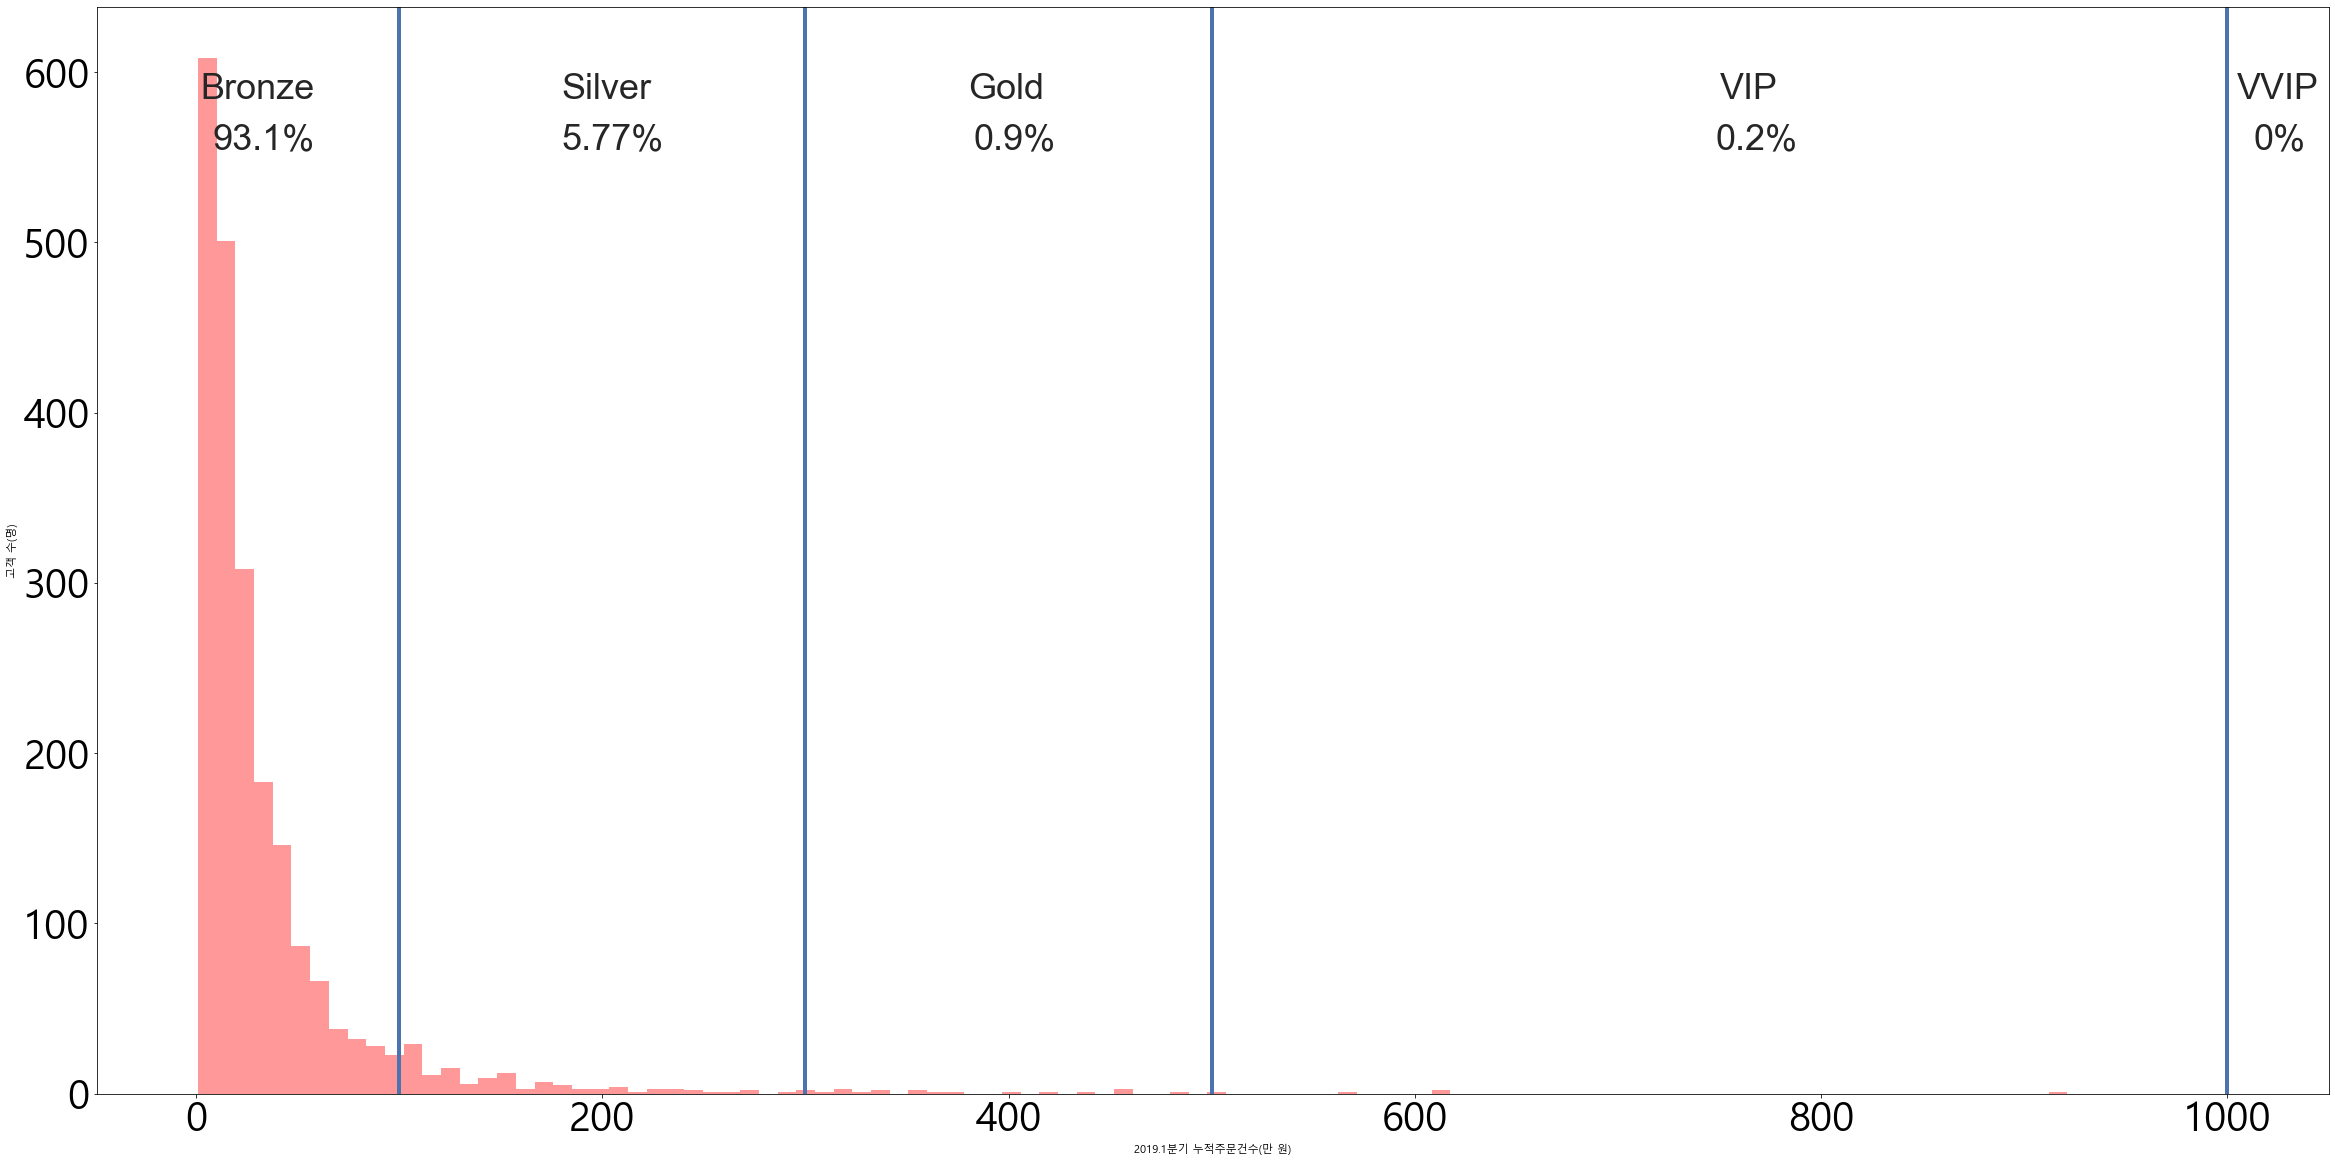

In [21]:

set_korea_font()
plt.figure(figsize=(40, 20)) 

# histogram
splot = sns.distplot(janmar.groupby('주문자ID').sum()['상품구매금액']/10000,kde=False, color='red', bins=100)
splot.tick_params(axis="x", labelsize=40)
splot.tick_params(axis="y", labelsize=40)
splot.set(xlabel='2019.1분기 누적주문건수(만 원)', ylabel='고객 수(명)')
#plt.xlabel('2019.1분기 누적주문건수(만 원)', ylabel='고객 수(명)'))
sns.set(font_scale=3)

splot.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
# vline
plt.axvline(x=100,linewidth=4)
plt.axvline(x=300,linewidth=4)
plt.axvline(x=500,linewidth=4)
plt.axvline(x=1000,linewidth=4)

splot.text(2, 600, "Bronze", ha="left", va="top")
splot.text(8, 570, "93.1%", ha="left", va="top")

splot.text(180, 600, "Silver", ha="left", va="top")
splot.text(180, 570, "5.77%", ha="left", va="top")

splot.text(380, 600, "Gold", ha="left", va="top")
splot.text(383, 570, "0.9%", ha="left", va="top")

splot.text(750, 600, "VIP", ha="left", va="top")
splot.text(748, 570, "0.2%", ha="left", va="top")

splot.text(1005, 600, "VVIP", ha="left", va="top")
splot.text(1013, 570, "0%", ha="left", va="top")
plt.show()

In [22]:
group = janmar.groupby('주문자ID').sum()['상품구매금액']
group.head()

주문자ID
2586-07-01 00:00:00     101640
1003409866             3088030
100381931                43980
1004498382               76400
1004547839              360800
Name: 상품구매금액, dtype: int64

In [23]:
bronze = group[group<1000000]
silver = group[(group>999999)&(group<3000000)]
gold =  group[(group>2999999)&(group<5000000)]
vip = group[(group>4999999)&(group<10000000)]
vvip = group[group>9999999]

In [24]:
print(bronze.shape, silver.shape, gold.shape, vip.shape, vvip.shape)

(2017,) (125,) (20,) (4,) (0,)


In [25]:
print( 'bronze (%) :', round(bronze.shape[0] / group.shape[0],2))
print( 'silver (%) :', round(silver.shape[0] / group.shape[0],2))
print( 'gold (%) :', round(gold.shape[0] / group.shape[0],2))
print( 'vip (%) :', round(vip.shape[0] / group.shape[0],2))
print( 'vvip (5) :', round(vvip.shape[0] / group.shape[0],2))

bronze (%) : 0.93
silver (%) : 0.06
gold (%) : 0.01
vip (%) : 0.0
vvip (5) : 0.0


### 문제상황 진단 완료.
> ### how to fix?

### 고칠 방향
>#### 1. "등급"의 개수 
>#### 2. "등급"별로 속하게 될 사람의 비율 ( "등급별"  CUT )
>#### 3. CUT의 기준 ( 누적 주문금액? 분기별 주문금액? )

- 기존의 체계 : 새내기 + 5등급 
- NEW : 5등급 ( 새내기 = bronze ) -> 현존 등급체계 혼란 방지 위해 5등급체계는 유지하는게 좋을 듯

In [26]:
group = group.sort_values()

In [27]:
group.head()

주문자ID
125880070     9360
41484517     10500
pp1445       11010
pp1395       11010
diningsen    11010
Name: 상품구매금액, dtype: int64

In [28]:
def grade(data,x1,x2,x3,x4):
    a = int(x1*len(data))
    b = int(x1*len(data)) + int(x2*len(data))
    c = int(x1*len(data)) + int(x2*len(data)) + int(x3*len(data))
    d = int(x1*len(data)) + int(x2*len(data)) + int(x3*len(data)) + int(x4*len(data))
    return data[:a],data[a:b],data[b:c],data[c:d],data[d:]

In [29]:
# bronze - silver - gold - vip - vvip
# 60% - 15% - 15% - 7.5% - 2.5%

In [30]:
g1,g2,g3,g4,g5 = grade(group,0.6,0.15,0.15,0.075)

In [31]:
g2.min(), g3.min(), g4.min(), g5.min()

(248840, 391250, 771900, 1743620)

## 등급 별 적정 금액 기준 컷은?

- bronze층이 과반수 이상을 차지하면서, 위로 갈수록 줄어드는 구조로 다양한 등급별 비율 조합 시행
- 그 결과 ,60%,15%,15%,7.5%,2.5%으로 하게 될 경우 금액 CUT기준이 가장 명확한 숫자. 

#### Bronze ~ Silver : 250,000 ( 248,840 )
#### Silver ~ Gold : 400,000 ( 391,250 )
#### Gold ~ VIP : 800,000 ( 771,900 ) 
#### VIP ~ VVIP : 1,800,000 ( 1,743,620 )

In [32]:
import scipy.stats as st

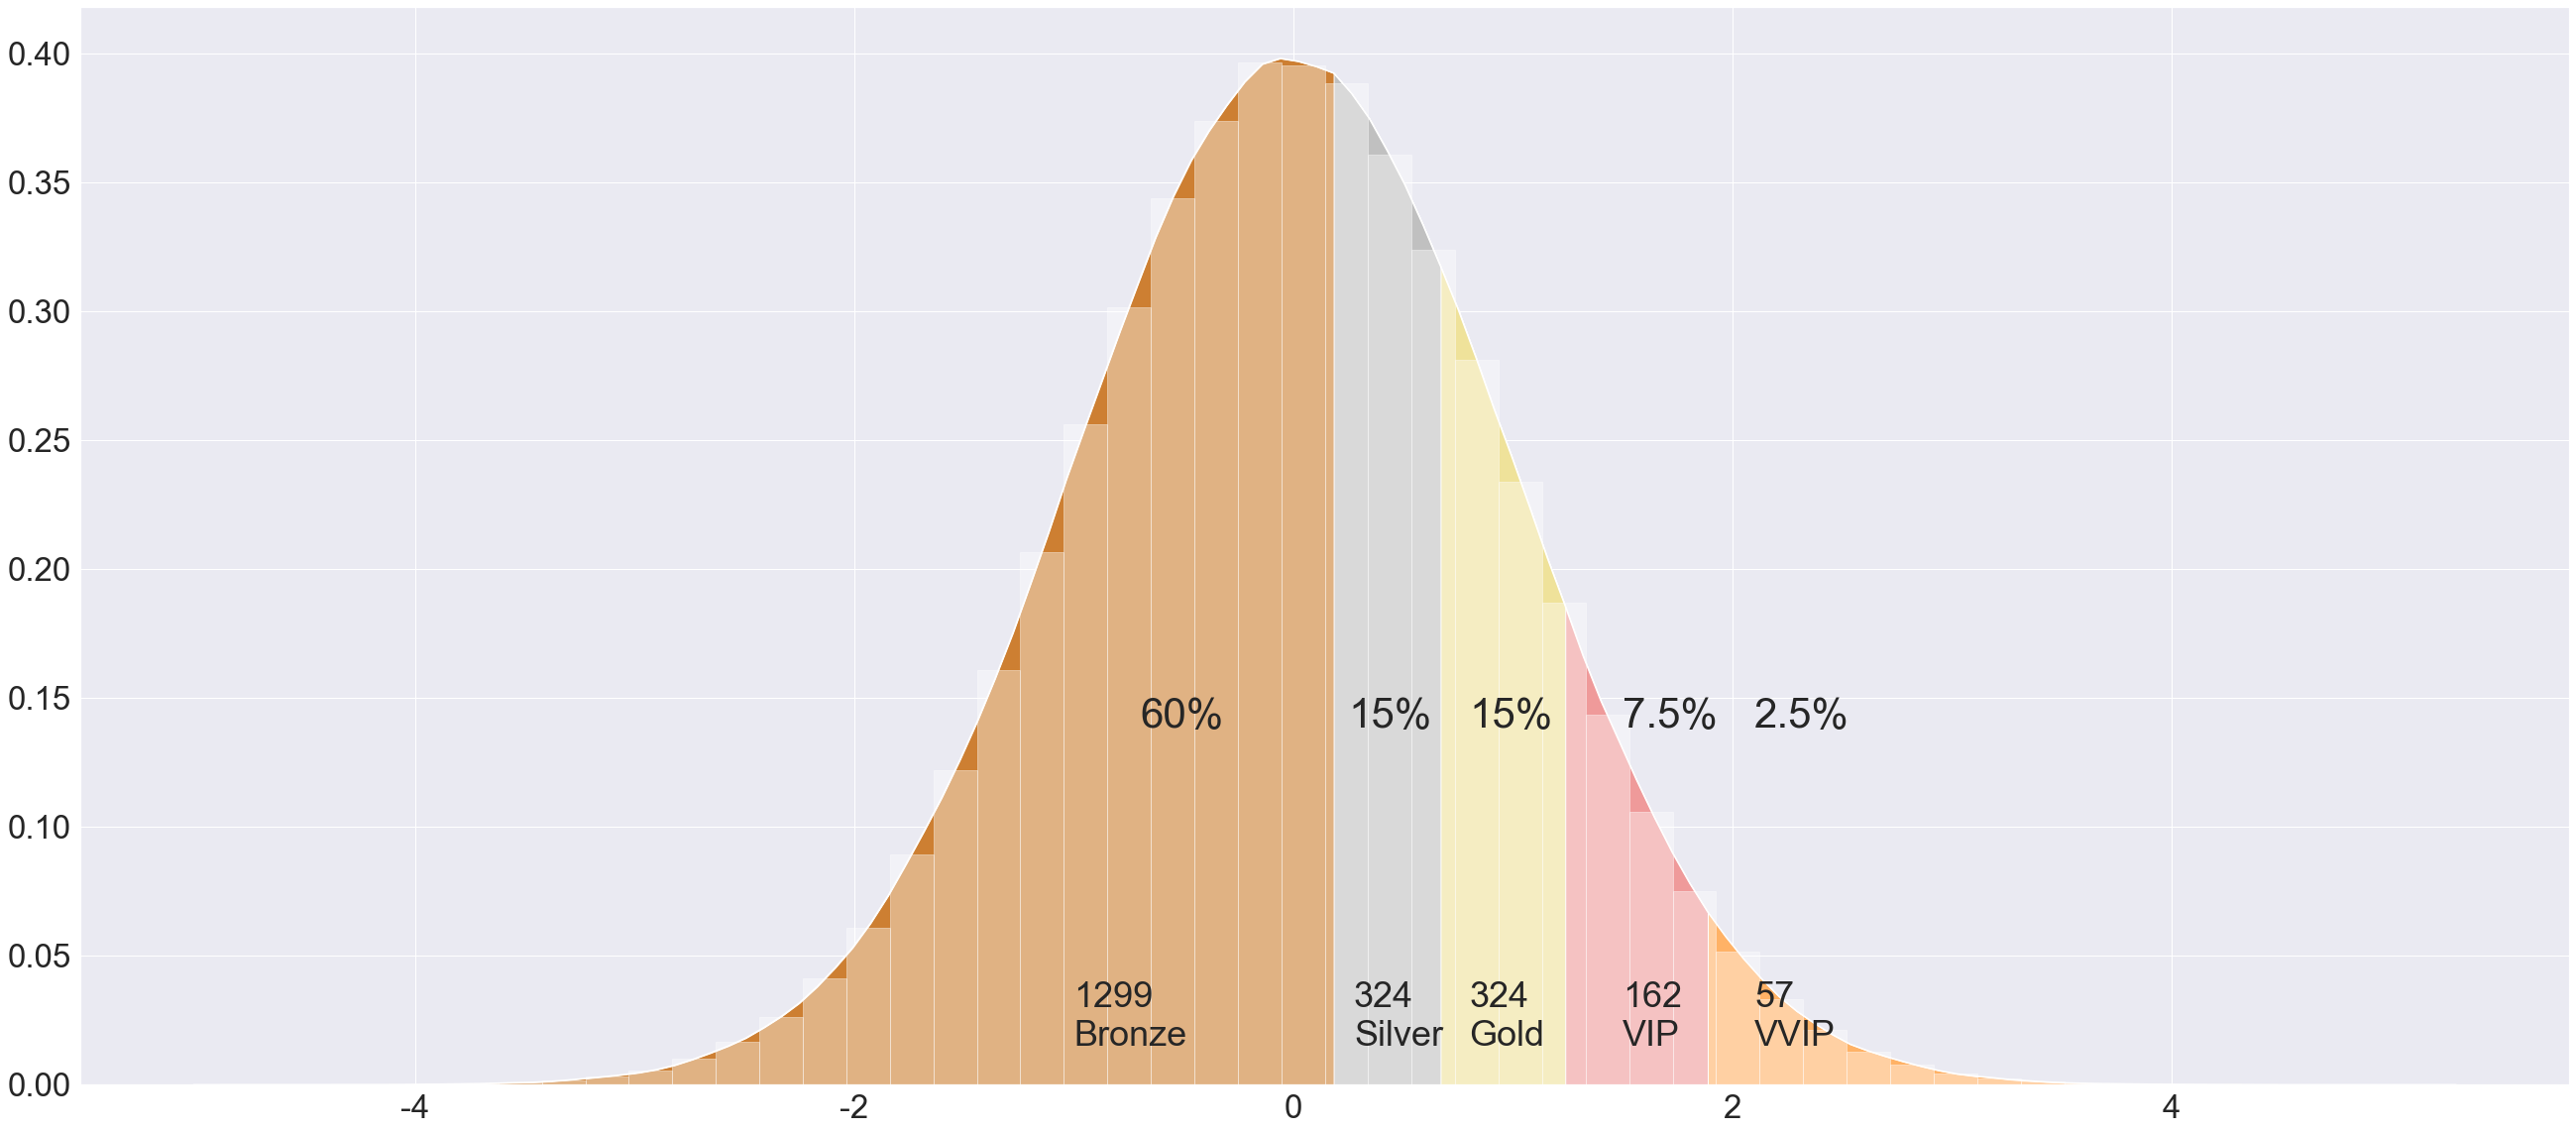

In [34]:
plt.figure(figsize=(45,20))

x = np.random.normal(size=999999)
ax = sns.distplot(x,color='white')
kde_x, kde_y = ax.lines[0].get_data()
    
ax.fill_between(kde_x, kde_y,facecolor='#ffb266')
ax.fill_between(kde_x, kde_y, where=(kde_x<st.norm.ppf(0.975)),facecolor='#EF9A9A')
ax.fill_between(kde_x, kde_y, where=(kde_x<st.norm.ppf(0.9)),facecolor='#efe29a')
ax.fill_between(kde_x, kde_y, where=(kde_x<st.norm.ppf(0.75)),facecolor='#c0c0c0')
ax.fill_between(kde_x, kde_y, where=(kde_x<st.norm.ppf(0.6)) , facecolor='#CD7F32')

sns.set(font_scale=3)
ax.text(-1,0.025, "Bronze", ha="left", va="top")
ax.text(-1,0.04, str(len(g1)), ha="left", va="top")

ax.text(0.275,0.025, "Silver", ha="left", va="top")
ax.text(0.275,0.04, len(g2), ha="left", va="top")

ax.text(0.8, 0.025, "Gold", ha="left", va="top")
ax.text(0.8, 0.04, len(g3), ha="left", va="top")

ax.text(1.5, 0.025, "VIP", ha="left", va="top")
ax.text(1.5, 0.04, len(g4), ha="left", va="top")

ax.text(2.1,0.025, "VVIP", ha="left", va="top")
ax.text(2.1,0.04, len(g5), ha="left", va="top")

sns.set(font_scale=3.5)
ax.text(-0.7,0.15, "60%", ha="left", va="top")
ax.text(0.25,0.15, '15%', ha="left", va="top")
ax.text(0.8, 0.15, '15%', ha="left", va="top")
ax.text(1.5, 0.15, '7.5%', ha="left", va="top")
ax.text(2.1,0.15, '2.5%', ha="left", va="top")

plt.show()

## 새로운 기준의 등급별 비교/분석

In [35]:
user = pd.read_excel('(통합)DB분석_회원관리서버.xlsx')

In [36]:
user['최종접속일'] = pd.to_datetime(user['최종접속일']).dt.to_period('D')
user['회원 가입일'] = pd.to_datetime(user['회원 가입일']).dt.to_period('D')
user['최종주문일'] = pd.to_datetime(user['최종주문일']).dt.to_period('D')
user['최종로그인일'] = pd.to_datetime(user['최종로그인일'], errors='coerce').dt.to_period('D')
user['최종로그인일'] = user['최종로그인일'].dt.to_timestamp()
user['휴면해제일'] = pd.to_datetime(user['휴면해제일'], errors='coerce').dt.to_period('D')
user['휴면해제일'] = user['휴면해제일'].dt.to_timestamp()

In [37]:
emailuser = user['아이디'].str.extract(r'(\w+)@(.+)').dropna()
indices = emailuser.index
user.loc[indices,'아이디'] = emailuser[0]
realfake = user[user.duplicated('아이디', keep=False)].sort_values('아이디').index
dupuser = user[user.duplicated('아이디', keep=False)].sort_values('아이디')[['아이디','최종로그인일']].dropna()
dupuser = dupuser[dupuser['최종로그인일']>pd.to_datetime('2010-01-01')]
dupuser = dupuser.sort_values('최종로그인일').drop_duplicates('아이디', keep='last')
dupindex = dupuser.index
realindex = user.index.difference(realfake).union(dupindex)
realuser = user.ix[realindex]

In [38]:
user.columns

Index(['가입시간', '나이', '누적주문건수', '별명', '사업자구분(P:개인사업자/C:법인사업자)', '사업자번호', '상호',
       '성별_x', ' 실결제금액 ', '아이디', ' 미가용 적립금 ', ' 사용가능 적립금 ', '주소(동/읍/면)', '지역',
       ' 총 방문횟수(1년 내) ', ' 총 사용 적립금 ', ' 총 실주문건수 ', ' 총구매금액 ', ' 총예치금 ',
       ' 총적립금 ', '최종접속일', '최종주문일', '추가사항1', '추가사항2', '추천인 아이디', '탈퇴여부', '특별회원',
       '평생회원', '회원 가입경로', '회원 가입일', '회원구분_x', '회원등급', '회원등급코드', '회원번호', '등록일',
       '가입경로', '최종로그인일', '휴면해제일', '회원구분_y', '등급', '주소', '주문건수', '주문금액', '마일리지',
       '예치금', '방문횟수', '업태', '종목', '추천인아이디', '성별_y'],
      dtype='object')

In [39]:
real = realuser[['아이디','누적주문건수','사업자구분(P:개인사업자/C:법인사업자)',' 총 사용 적립금 ',' 총구매금액 ',
               ' 총적립금 ','최종접속일','추천인아이디','회원 가입일','회원구분_x','회원등급']]
real = real.rename(columns=lambda x: x.strip())

In [40]:
real[['총 사용 적립금','총구매금액','총적립금']] = real[['총 사용 적립금','총구매금액','총적립금']].apply(lambda x : x.str.strip() )
real[['총 사용 적립금','총구매금액','총적립금']] = real[['총 사용 적립금','총구매금액','총적립금']].apply(lambda x : x.str.replace(',',''))
real[['총 사용 적립금','총구매금액','총적립금']] = real[['총 사용 적립금','총구매금액','총적립금']].apply(lambda x : x.str.replace('원',''))
real[['총 사용 적립금','총구매금액','총적립금']] = real[['총 사용 적립금','총구매금액','총적립금']].apply(lambda x : x.str.replace('-',''))
real[['총 사용 적립금','총구매금액','총적립금']] = real[['총 사용 적립금','총구매금액','총적립금']].apply(lambda x : x.str.extract('(\d+)', expand=False))
real[['총 사용 적립금','총구매금액','총적립금']] = real[['총 사용 적립금','총구매금액','총적립금']].astype('float')

In [41]:
real['추천인아이디'] = np.where(real['추천인아이디'].isnull(), 0, 1)

In [42]:
realuser = pd.merge(real,pd.DataFrame(group).reset_index(),left_on='아이디',right_on='주문자ID').drop('주문자ID',axis=1)

In [44]:
realuser['GROUP']='x'
realuser.loc[realuser.아이디.isin(g1.index),'GROUP']='Bronze'
realuser.loc[realuser.아이디.isin(g2.index),'GROUP']='Silver'
realuser.loc[realuser.아이디.isin(g3.index),'GROUP']='Gold'
realuser.loc[realuser.아이디.isin(g4.index),'GROUP']='VIP'
realuser.loc[realuser.아이디.isin(g5.index),'GROUP']='VVIP'

In [46]:
names = realuser.columns.tolist()
names[names.index('상품구매금액')] = '2019.1분기'
realuser.columns = names

In [48]:
realuser['총적립금']=realuser['총적립금'].fillna(0)
realuser['총 사용 적립금']=realuser['총 사용 적립금'].fillna(0)

In [49]:
realuser.groupby('GROUP').mean()

,누적주문건수,총 사용 적립금,총구매금액,총적립금,추천인아이디,2019.1분기
GROUP,,,,,,
Bronze,3.456454,1146.160370,3.805314e+05,2866.173477,0.024672,1.174701e+05
Gold,11.441358,9061.123457,1.585097e+06,12839.808642,0.046296,5.305955e+05
Silver,8.040248,5874.354938,1.004542e+06,9183.444444,0.040123,3.097434e+05
VIP,21.802469,27701.351852,3.638355e+06,34310.296296,0.055556,1.099550e+06
VVIP,40.964912,87823.754386,8.620380e+06,97880.824561,0.157895,3.074438e+06


In [50]:
# 2164명 -> 2152명
# 11명의 bronze 유저, 1명의 silver유저 사라짐
realuser = realuser.dropna()

In [51]:
user = pd.read_csv('2x2_user.csv')

In [53]:
Total = pd.merge(realuser,user[['아이디','cluster','주문서 쿠폰 할인금액']],left_on='아이디',right_on='아이디',how='outer')

In [54]:
Total = Total[Total['아이디'].isin(realuser['아이디'])]

In [55]:
G1 = Total[Total['GROUP']=='Bronze']
G2 = Total[Total['GROUP']=='Silver']
G3 = Total[Total['GROUP']=='Gold']
G4 = Total[Total['GROUP']=='VIP']
G5 = Total[Total['GROUP']=='VVIP']

In [56]:
Total.head()

,아이디,누적주문건수,사업자구분(P:개인사업자/C:법인사업자),총 사용 적립금,총구매금액,총적립금,최종접속일,추천인아이디,회원 가입일,회원구분_x,회원등급,2019.1분기,GROUP,cluster,주문서 쿠폰 할인금액
0,kyen1311,7.0,법인사업자,0.0,688760.0,5820.0,2019-03-24,1.0,2017-03-03,사업자,사업자,210640.0,Bronze,NaN,NaN
1,xigol80,22.0,법인사업자,79600.0,3615630.0,87750.0,2019-05-03,0.0,2017-03-08,사업자,사업자,267430.0,Silver,NaN,NaN
2,hanwoori,29.0,,0.0,4729114.0,0.0,2019-05-13,0.0,2017-03-29,개인,전화주문 고객,1121540.0,VIP,NaN,NaN
3,pinkbabi100,20.0,법인사업자,60180.0,2094550.0,62020.0,2019-05-17,0.0,2017-04-09,사업자,사업자,223600.0,Bronze,NaN,NaN
4,yyk1104,105.0,법인사업자,128217.0,6412060.0,132197.0,2019-05-09,0.0,2017-04-24,사업자,사업자,382740.0,Silver,NaN,NaN


In [57]:
Total['사용적립금/구매금액'] = Total['총 사용 적립금']/Total['총구매금액']

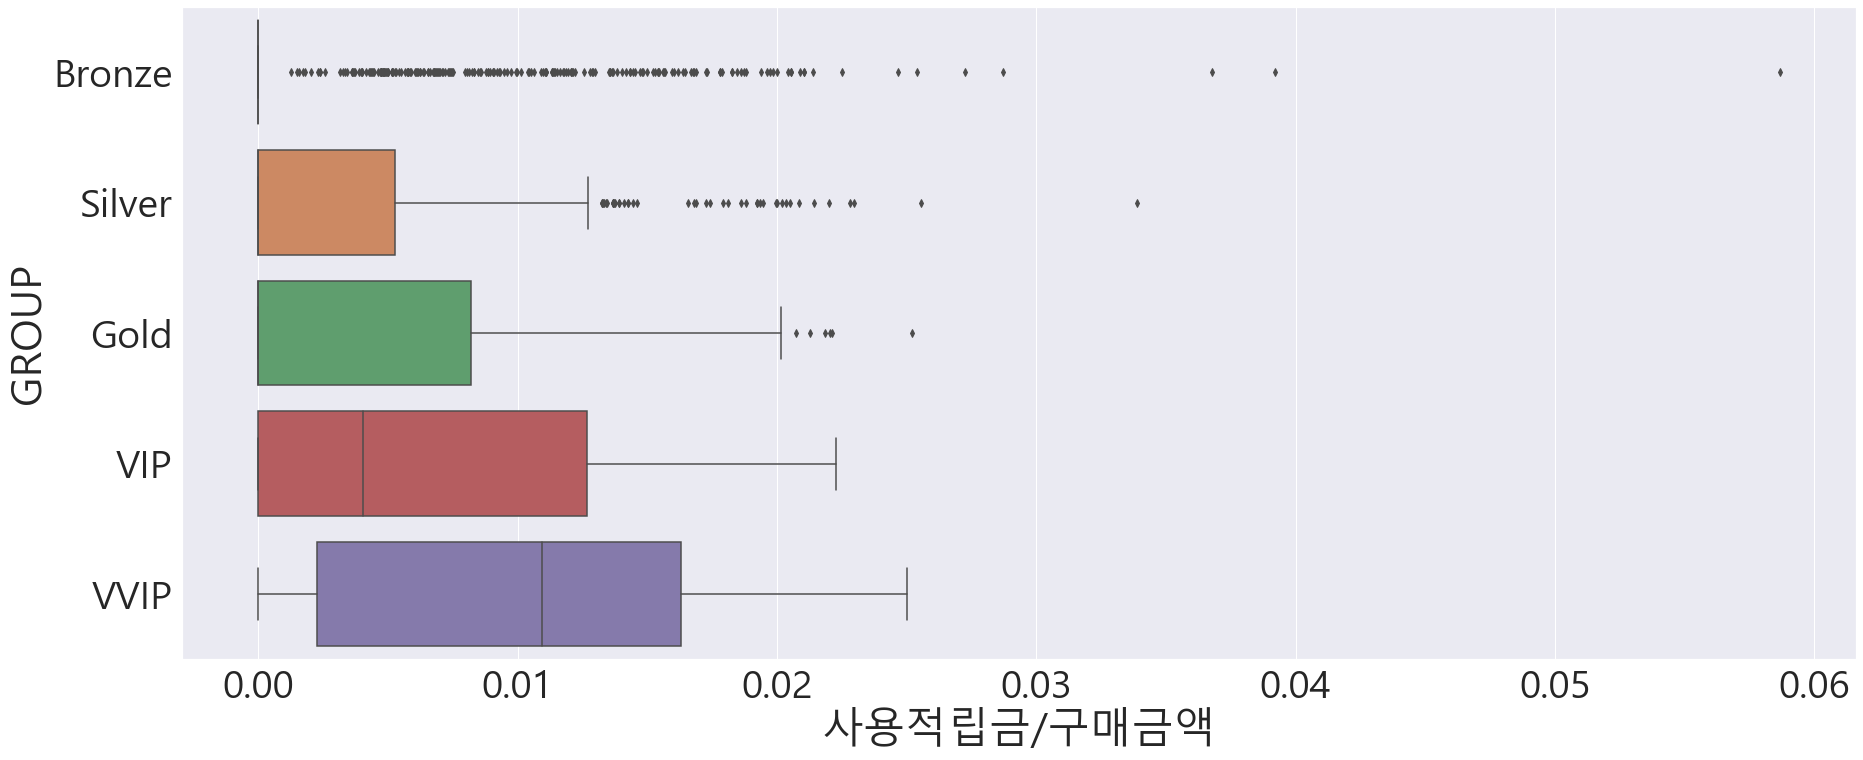

In [58]:
set_korea_font()
plt.figure(figsize=(30,12))
sns.boxplot(x='사용적립금/구매금액',y='GROUP',order=['Bronze','Silver','Gold','VIP','VVIP'],data=Total)
plt.show()

# 5개의 GROUP 별로 확인하고 싶은 비교점?

#### 1) 어떤 Cluster에 속하나?
- 위에서 SOM(2x2) clustering한 label 붙이기

#### 2) "회원가입일" 
- 언제 가입한 애들인가? 

#### 3) "누적주문건수" 
- 이번 분기 말고, 이전에도 많이 소비했던 애들인가?

#### 4) "총주문금액" 
- 이번 분기 말고, 이전에도 많이 소비했던 애들인가?

#### 5) "건당 주문 금액"
- 사는 품목이 비싼 것인가?

#### 6) "추천인아이디" 
- 추천인 아이디를 통해 들어온 애들의 소비행태를 파악?

#### 7) "총 사용 적립금 & 총 적립금" 
- 마일리지를 준다면, 쓸 애들인가? 

>### 결론 : "각 등급별로 XXX 혜택을 주는 것이 좋다" 
-> 여기서 제안해줄 때 ML 이용할 수 있는 방법은 없겠지....?그냥 표 보고 대충 이러이러하는게 낫겟다 가볍게 제안해야하나...

### 1) 어떤 Cluster에 속하는가?

In [64]:
print('Bronze의 outlier cluster :',G1['cluster'].isna().sum() / len(G1['cluster']))
print('Silver의 outlier cluster :',G2['cluster'].isna().sum() / len(G2['cluster']))
print('Gold의 outlier cluster :',G3['cluster'].isna().sum() / len(G3['cluster']))
print('VIP의 outlier cluster :',G4['cluster'].isna().sum() / len(G4['cluster']))
print('VVIP의 outlier cluster :',G5['cluster'].isna().sum() / len(G5['cluster']))

Bronze의 outlier cluster : 0.03421461897356143
Silver의 outlier cluster : 0.13003095975232198
Gold의 outlier cluster : 0.2716049382716049
VIP의 outlier cluster : 0.7098765432098766
VVIP의 outlier cluster : 0.9824561403508771


In [65]:
Total['cluster'] = Total['cluster'].fillna('outlier')

In [66]:
G1 = Total[Total['GROUP']=='Bronze']
G2 = Total[Total['GROUP']=='Silver']
G3 = Total[Total['GROUP']=='Gold']
G4 = Total[Total['GROUP']=='VIP']
G5 = Total[Total['GROUP']=='VVIP']

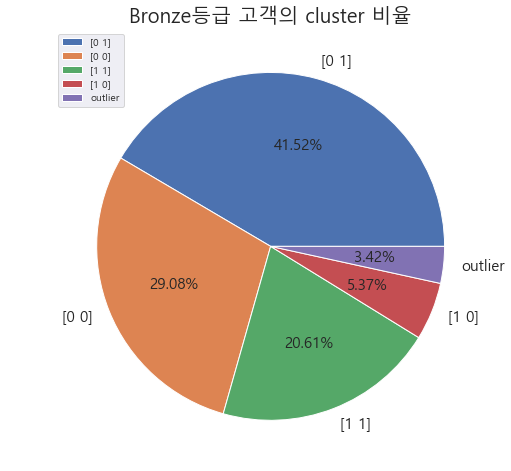

In [67]:
set_korea_font()
plt.figure(figsize=(8,8))
g1_cluster = G1['cluster'].value_counts()
g1_cluster.plot.pie(autopct='%.2f%%',textprops={'fontsize': 15})
plt.legend(loc=2, prop={'size': 10})
plt.title('Bronze등급 고객의 cluster 비율', size=20)
plt.ylabel(' ')
plt.show()

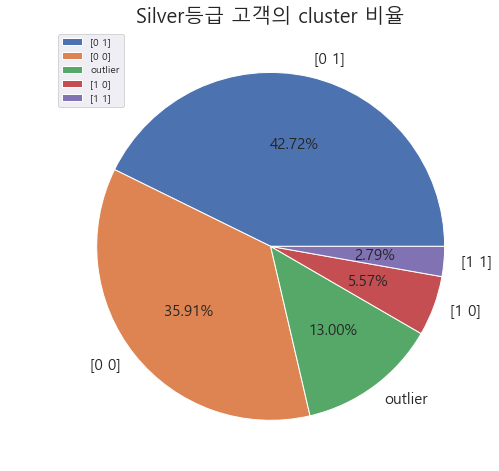

In [68]:
set_korea_font()
plt.figure(figsize=(8,8))
g2_cluster = G2['cluster'].value_counts()
g2_cluster.plot.pie(autopct='%.2f%%',textprops={'fontsize': 15})
plt.legend(loc=2, prop={'size': 10})
plt.title('Silver등급 고객의 cluster 비율', size=20)
plt.ylabel(' ')
plt.show()

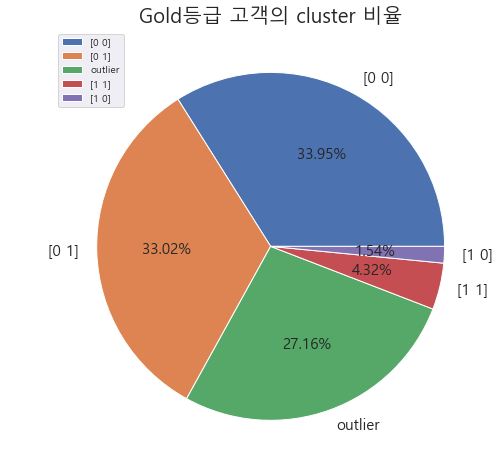

In [69]:
set_korea_font()
plt.figure(figsize=(8,8))
g3_cluster = G3['cluster'].value_counts()
g3_cluster.plot.pie(autopct='%.2f%%',textprops={'fontsize': 15})
plt.legend(loc=2, prop={'size': 10})
plt.title('Gold등급 고객의 cluster 비율', size=20)
plt.ylabel(' ')
plt.show()

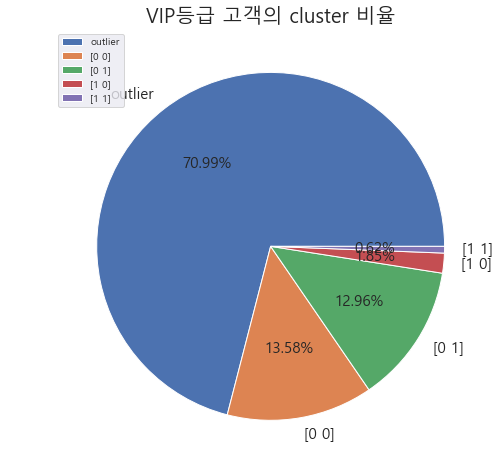

In [70]:
plt.figure(figsize=(8,8))
g4_cluster = G4['cluster'].value_counts()
g4_cluster.plot.pie(autopct='%.2f%%',textprops={'fontsize': 15})
plt.legend(loc=2, prop={'size': 10})
plt.title('VIP등급 고객의 cluster 비율', size=20)
plt.ylabel(' ')
plt.show()

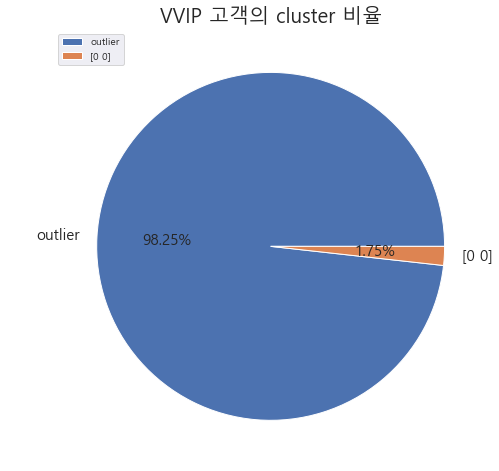

In [71]:
plt.figure(figsize=(8,8))
g5_cluster = G5['cluster'].value_counts()
g5_cluster.plot.pie(autopct='%.2f%%',textprops={'fontsize': 15})
plt.legend(loc=2, prop={'size': 10})
plt.title('VVIP 고객의 cluster 비율', size=20)
plt.ylabel(' ')
plt.show()

### 2) 회원 가입일

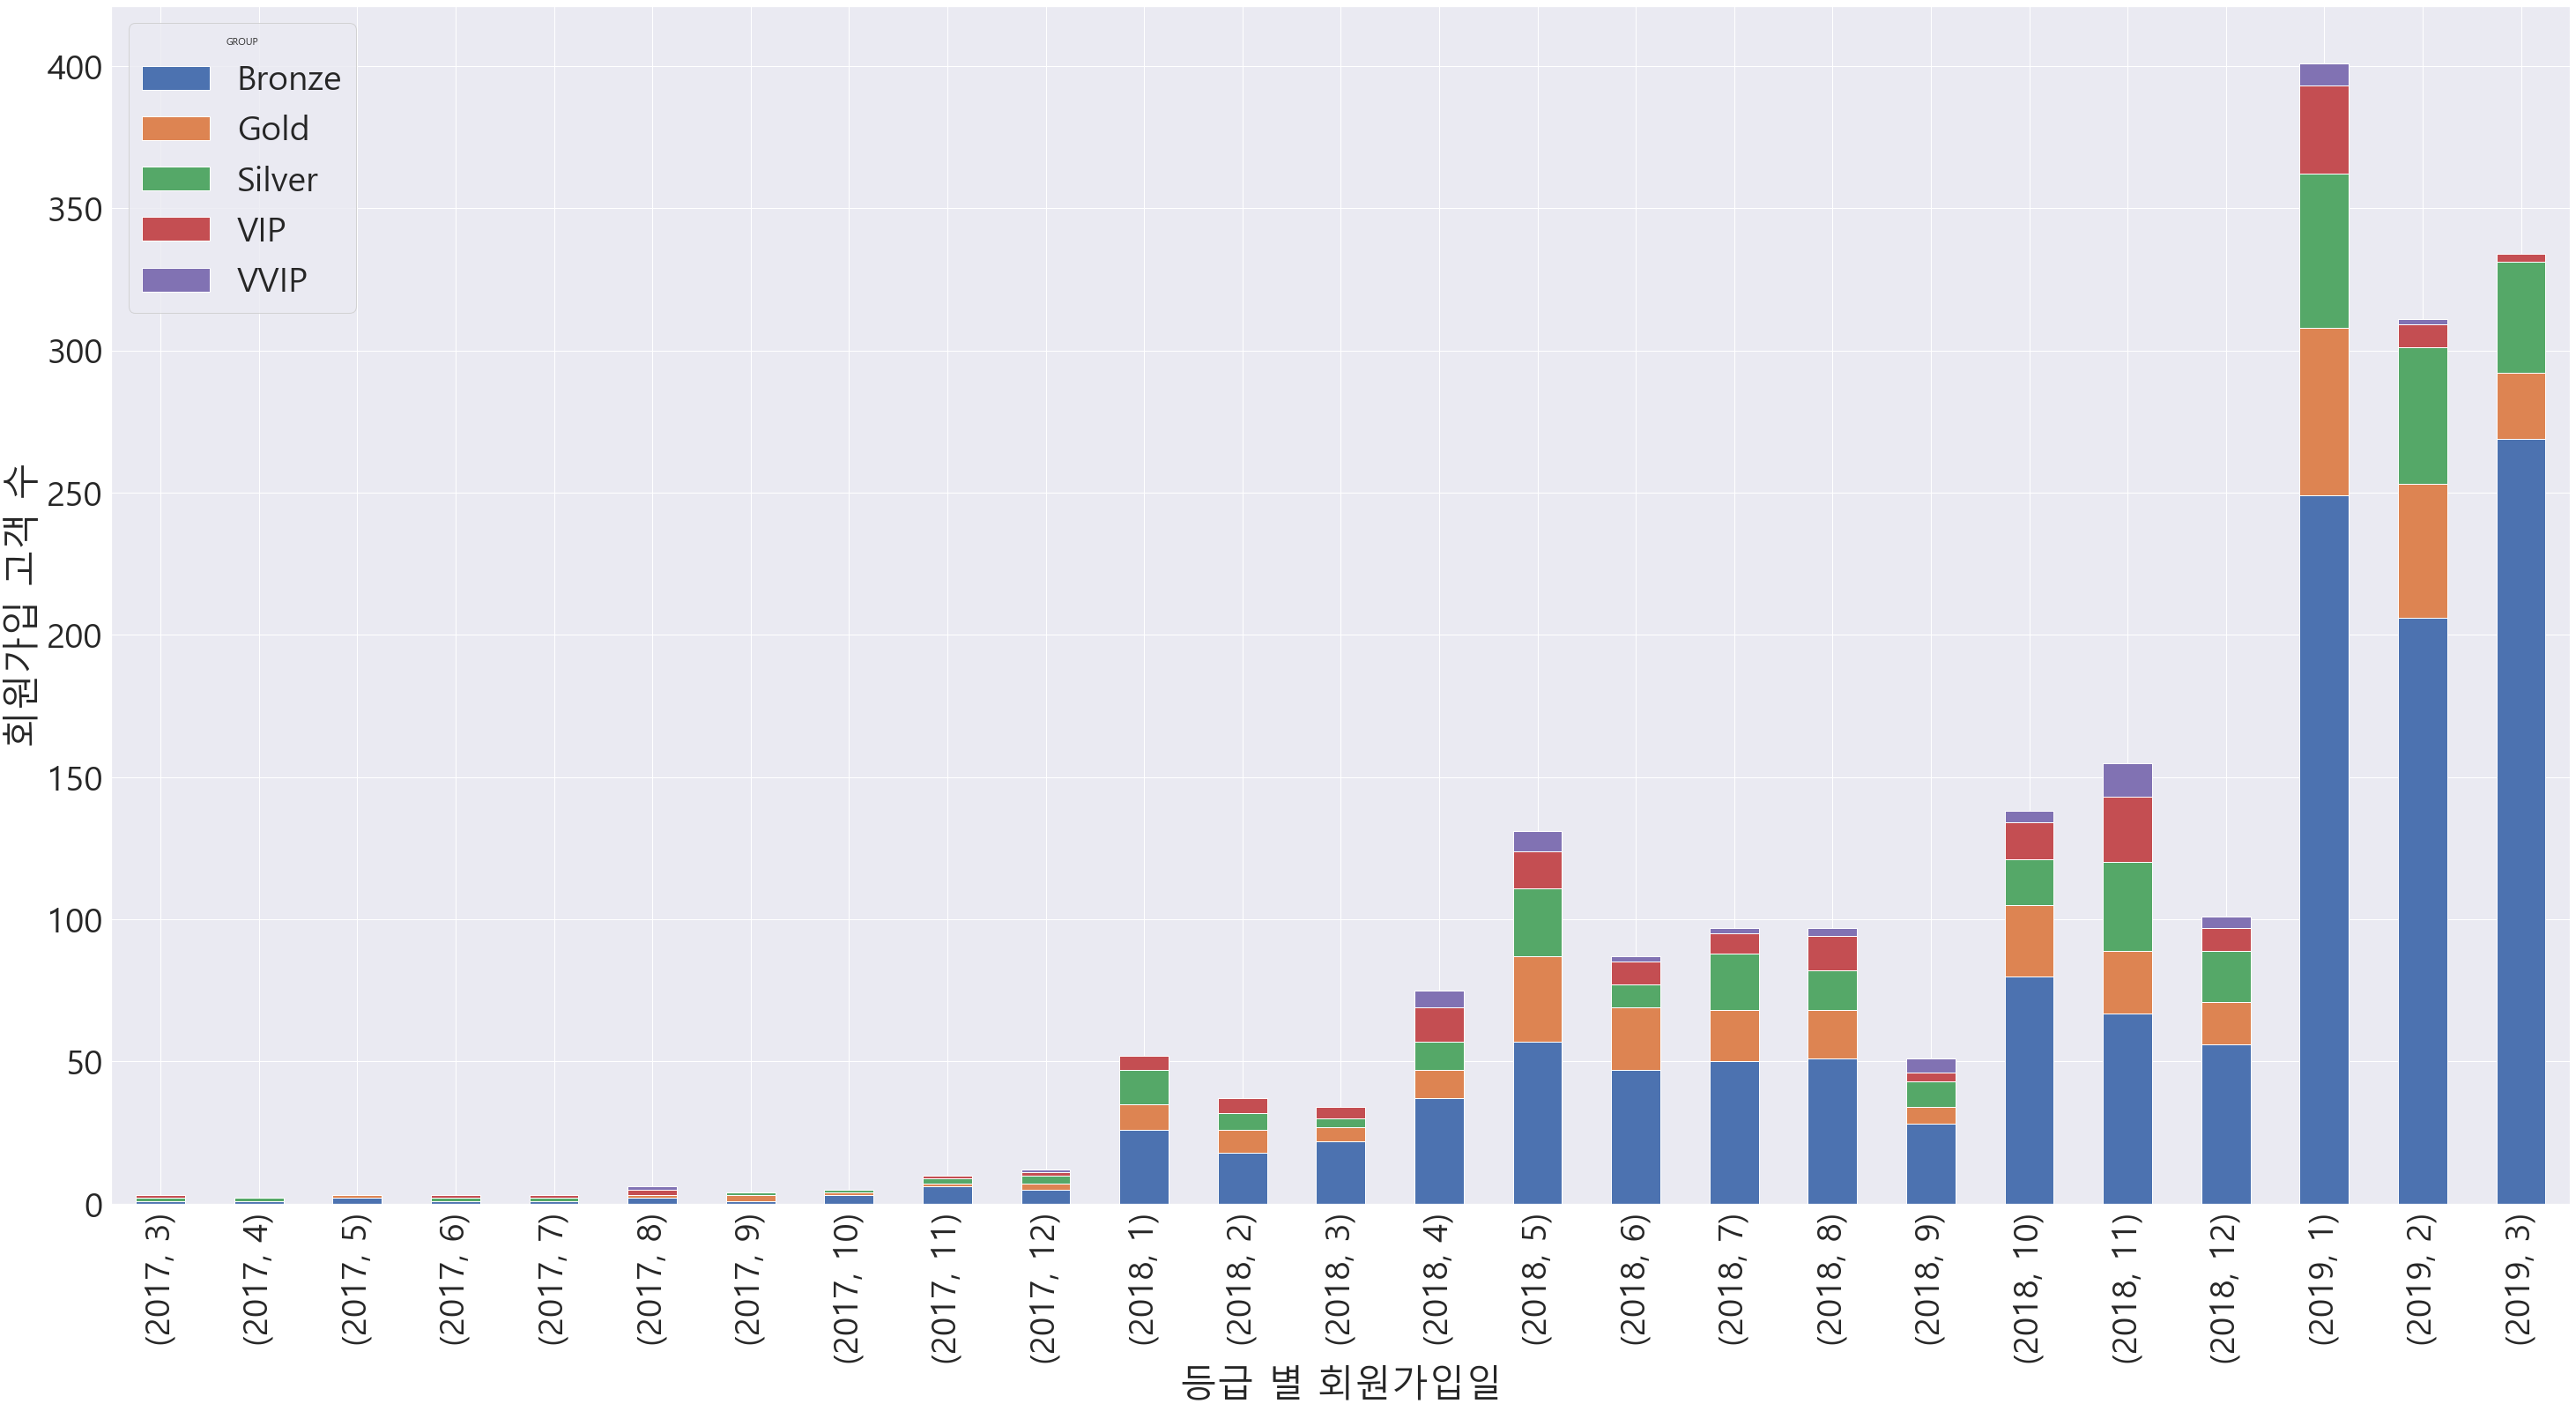

In [72]:
Total.groupby([Total["회원 가입일"].dt.year, Total["회원 가입일"].dt.month,'GROUP']).count()['아이디'].unstack().plot(kind='bar', stacked=True, figsize=(50, 25))
plt.xlabel('등급 별 회원가입일')
plt.ylabel('회원가입 고객 수')
plt.show()

### 3) 누적 주문 건수
- 2019.1분기에만 해당하는 것 아님 ( 전체 기간 누적 )

In [73]:
Total.groupby('GROUP').mean()['누적주문건수']

GROUP
Bronze     3.456454
Gold      11.441358
Silver     8.040248
VIP       21.802469
VVIP      40.964912
Name: 누적주문건수, dtype: float64

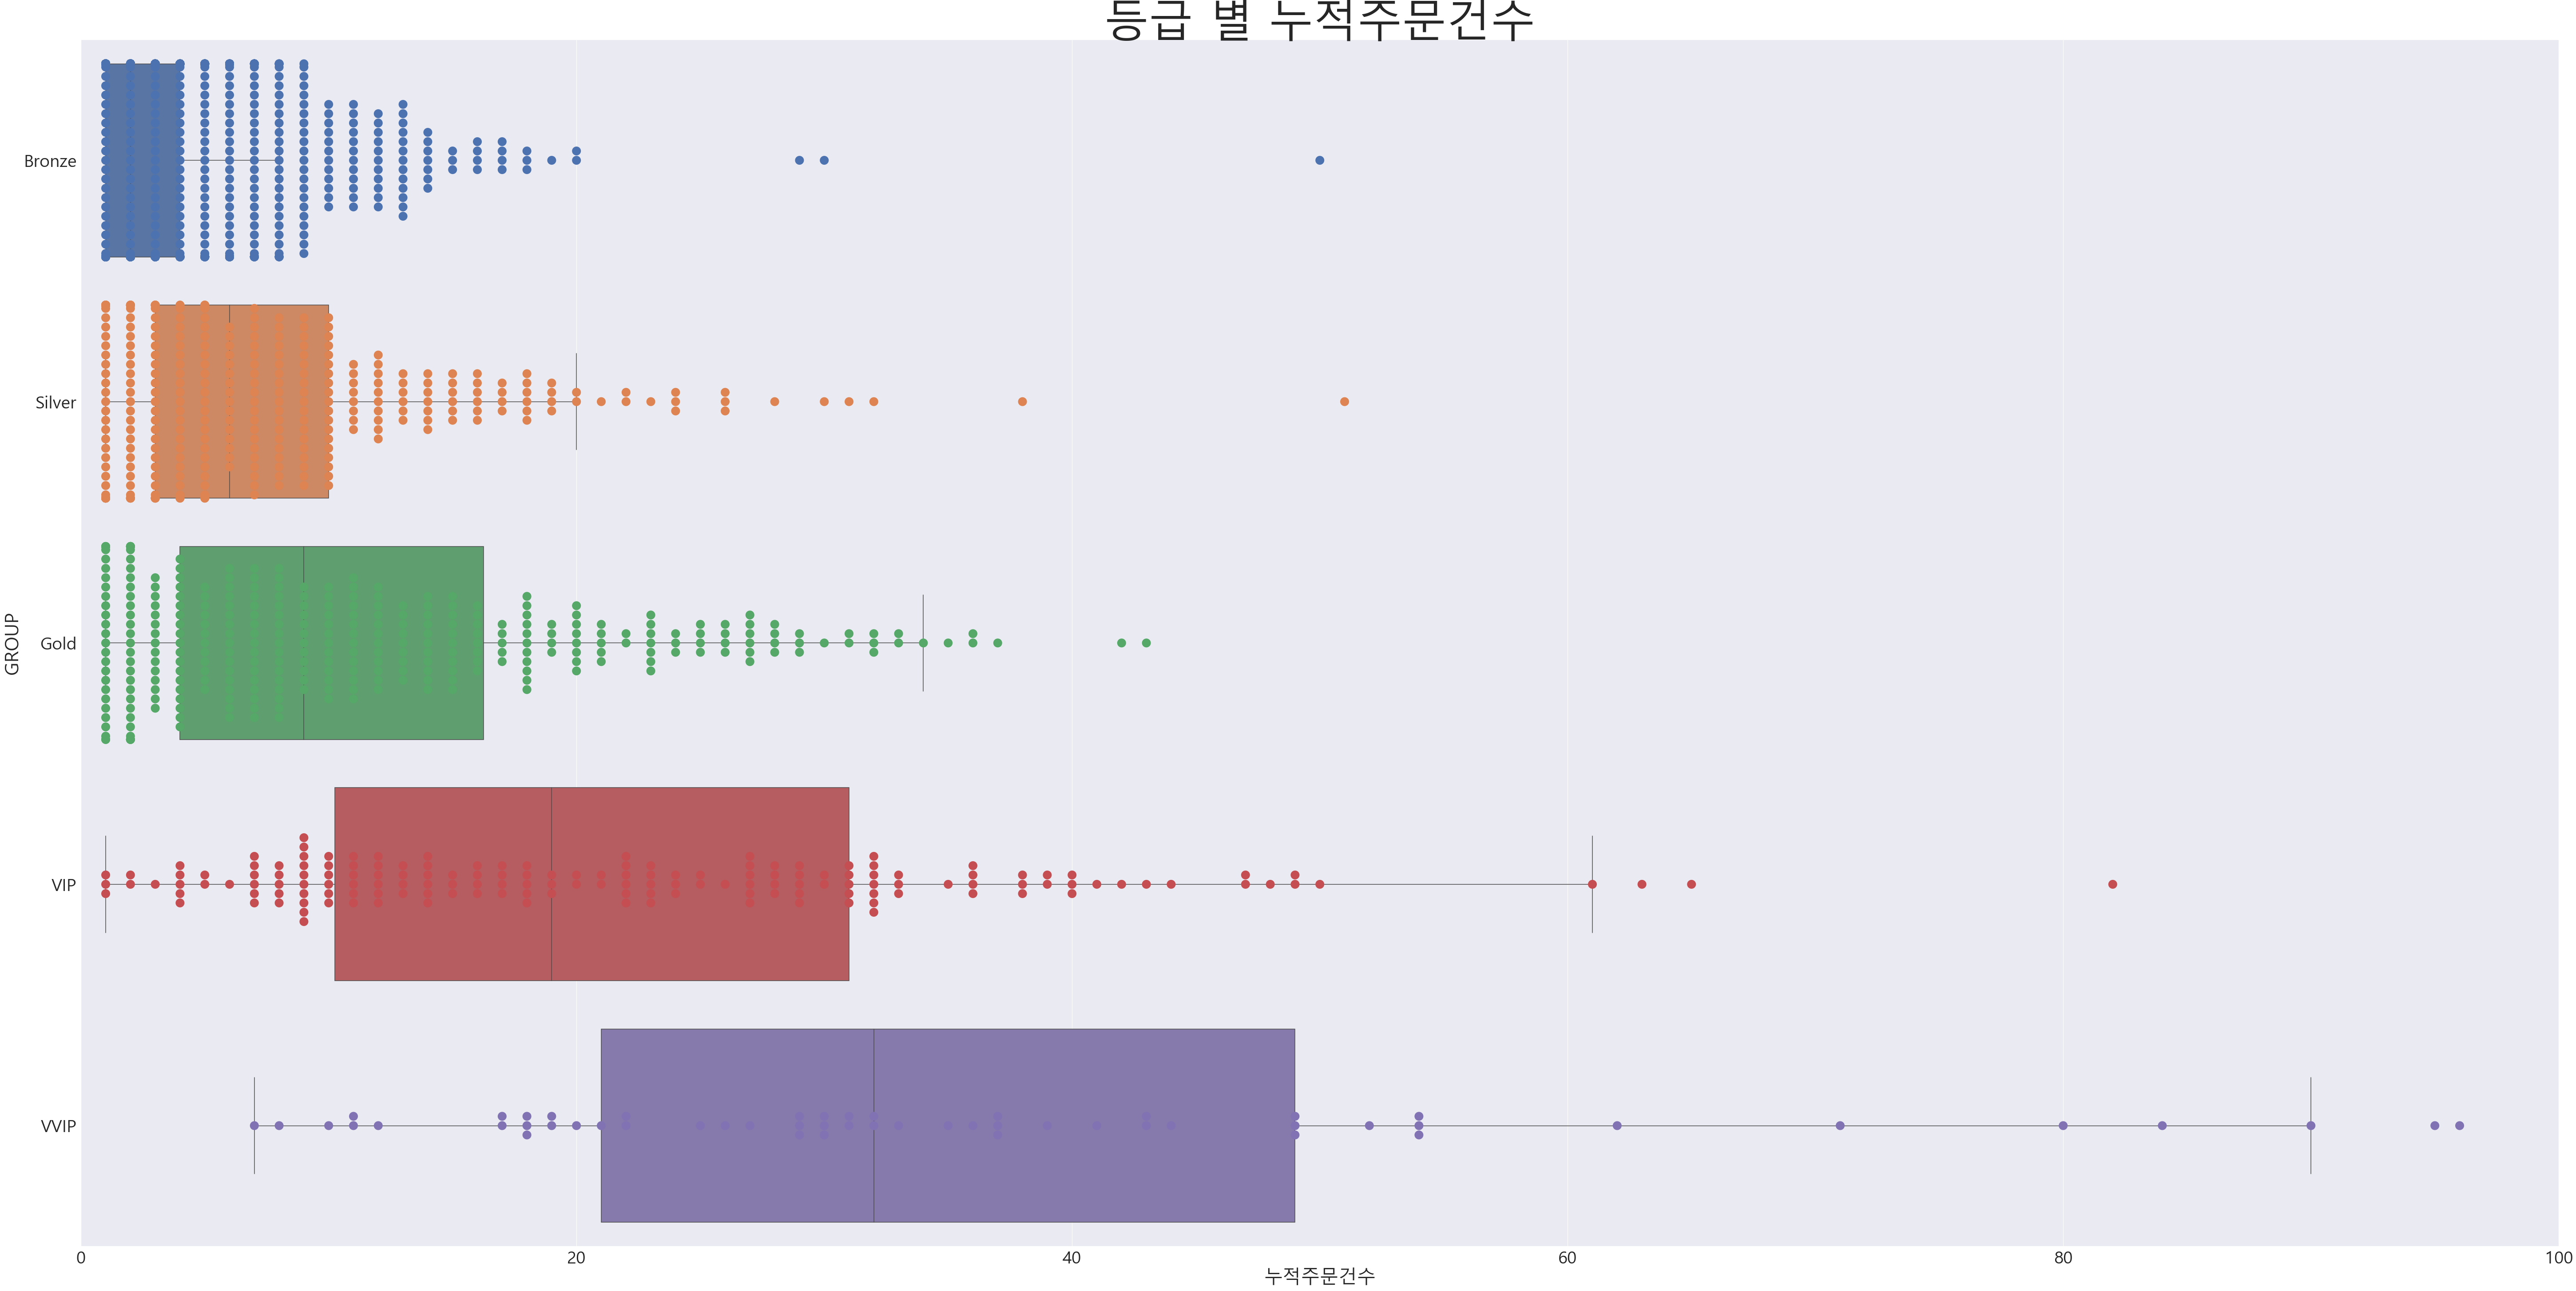

In [74]:
plt.figure(figsize=(100,50))
plt.title('등급 별 누적주문건수',size=100)

box = sns.boxplot(x='누적주문건수',y='GROUP',order=['Bronze','Silver','Gold','VIP','VVIP'],data=Total)
swarm = sns.swarmplot(x='누적주문건수',y='GROUP',order=['Bronze','Silver','Gold','VIP','VVIP'],data=Total,size=20)
box.set_xlim(0,100)
plt.show()

### 4) 총 구매금액

In [75]:
Total.groupby('GROUP').mean()['총구매금액'].round(-3)

GROUP
Bronze     381000.0
Gold      1585000.0
Silver    1005000.0
VIP       3638000.0
VVIP      8620000.0
Name: 총구매금액, dtype: float64

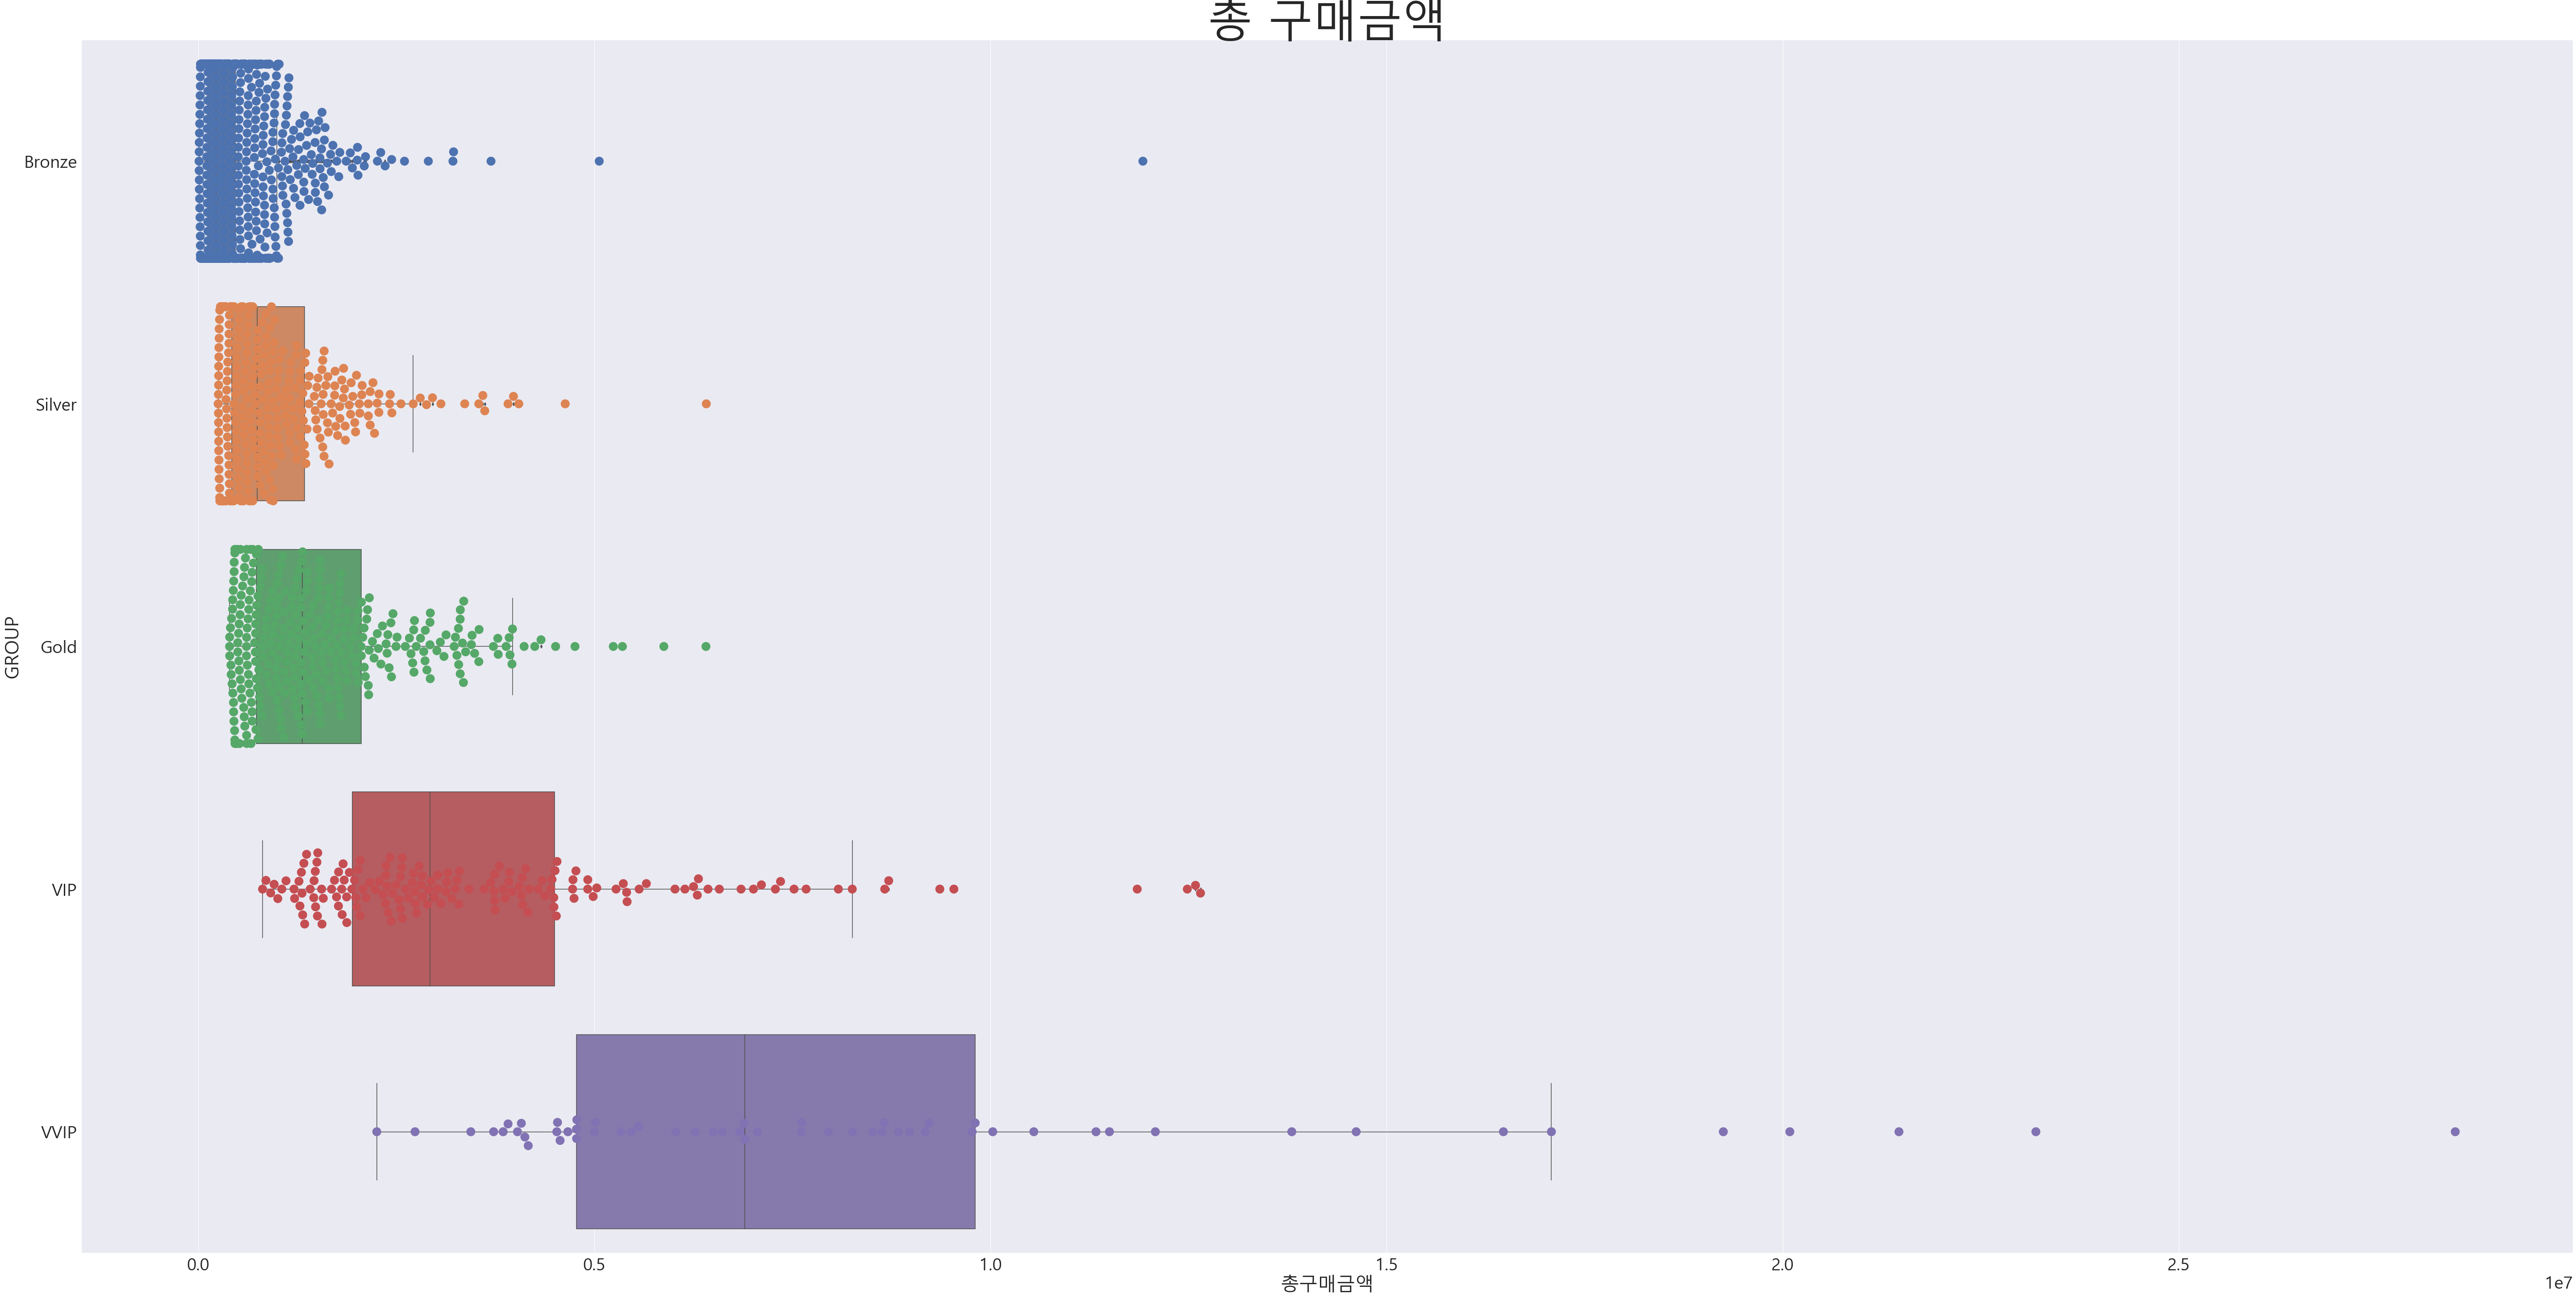

In [81]:
plt.figure(figsize=(100,50))
plt.title('총 구매금액',size=100)

box = sns.boxplot(x='총구매금액',y='GROUP',order=['Bronze','Silver','Gold','VIP','VVIP'],data=Total)
swarm = sns.swarmplot(x='총구매금액',y='GROUP',order=['Bronze','Silver','Gold','VIP','VVIP'],data=Total,size=20)
plt.show()

### 5) (구매 건수 대비) 구매 금액

In [77]:
Total['건당 구매 금액'] = Total['총구매금액'] / Total['누적주문건수']

In [78]:
Total.groupby('GROUP').mean()['건당 구매 금액'].round(-2)

GROUP
Bronze    106600.0
Gold      195300.0
Silver    161500.0
VIP       209100.0
VVIP      263900.0
Name: 건당 구매 금액, dtype: float64

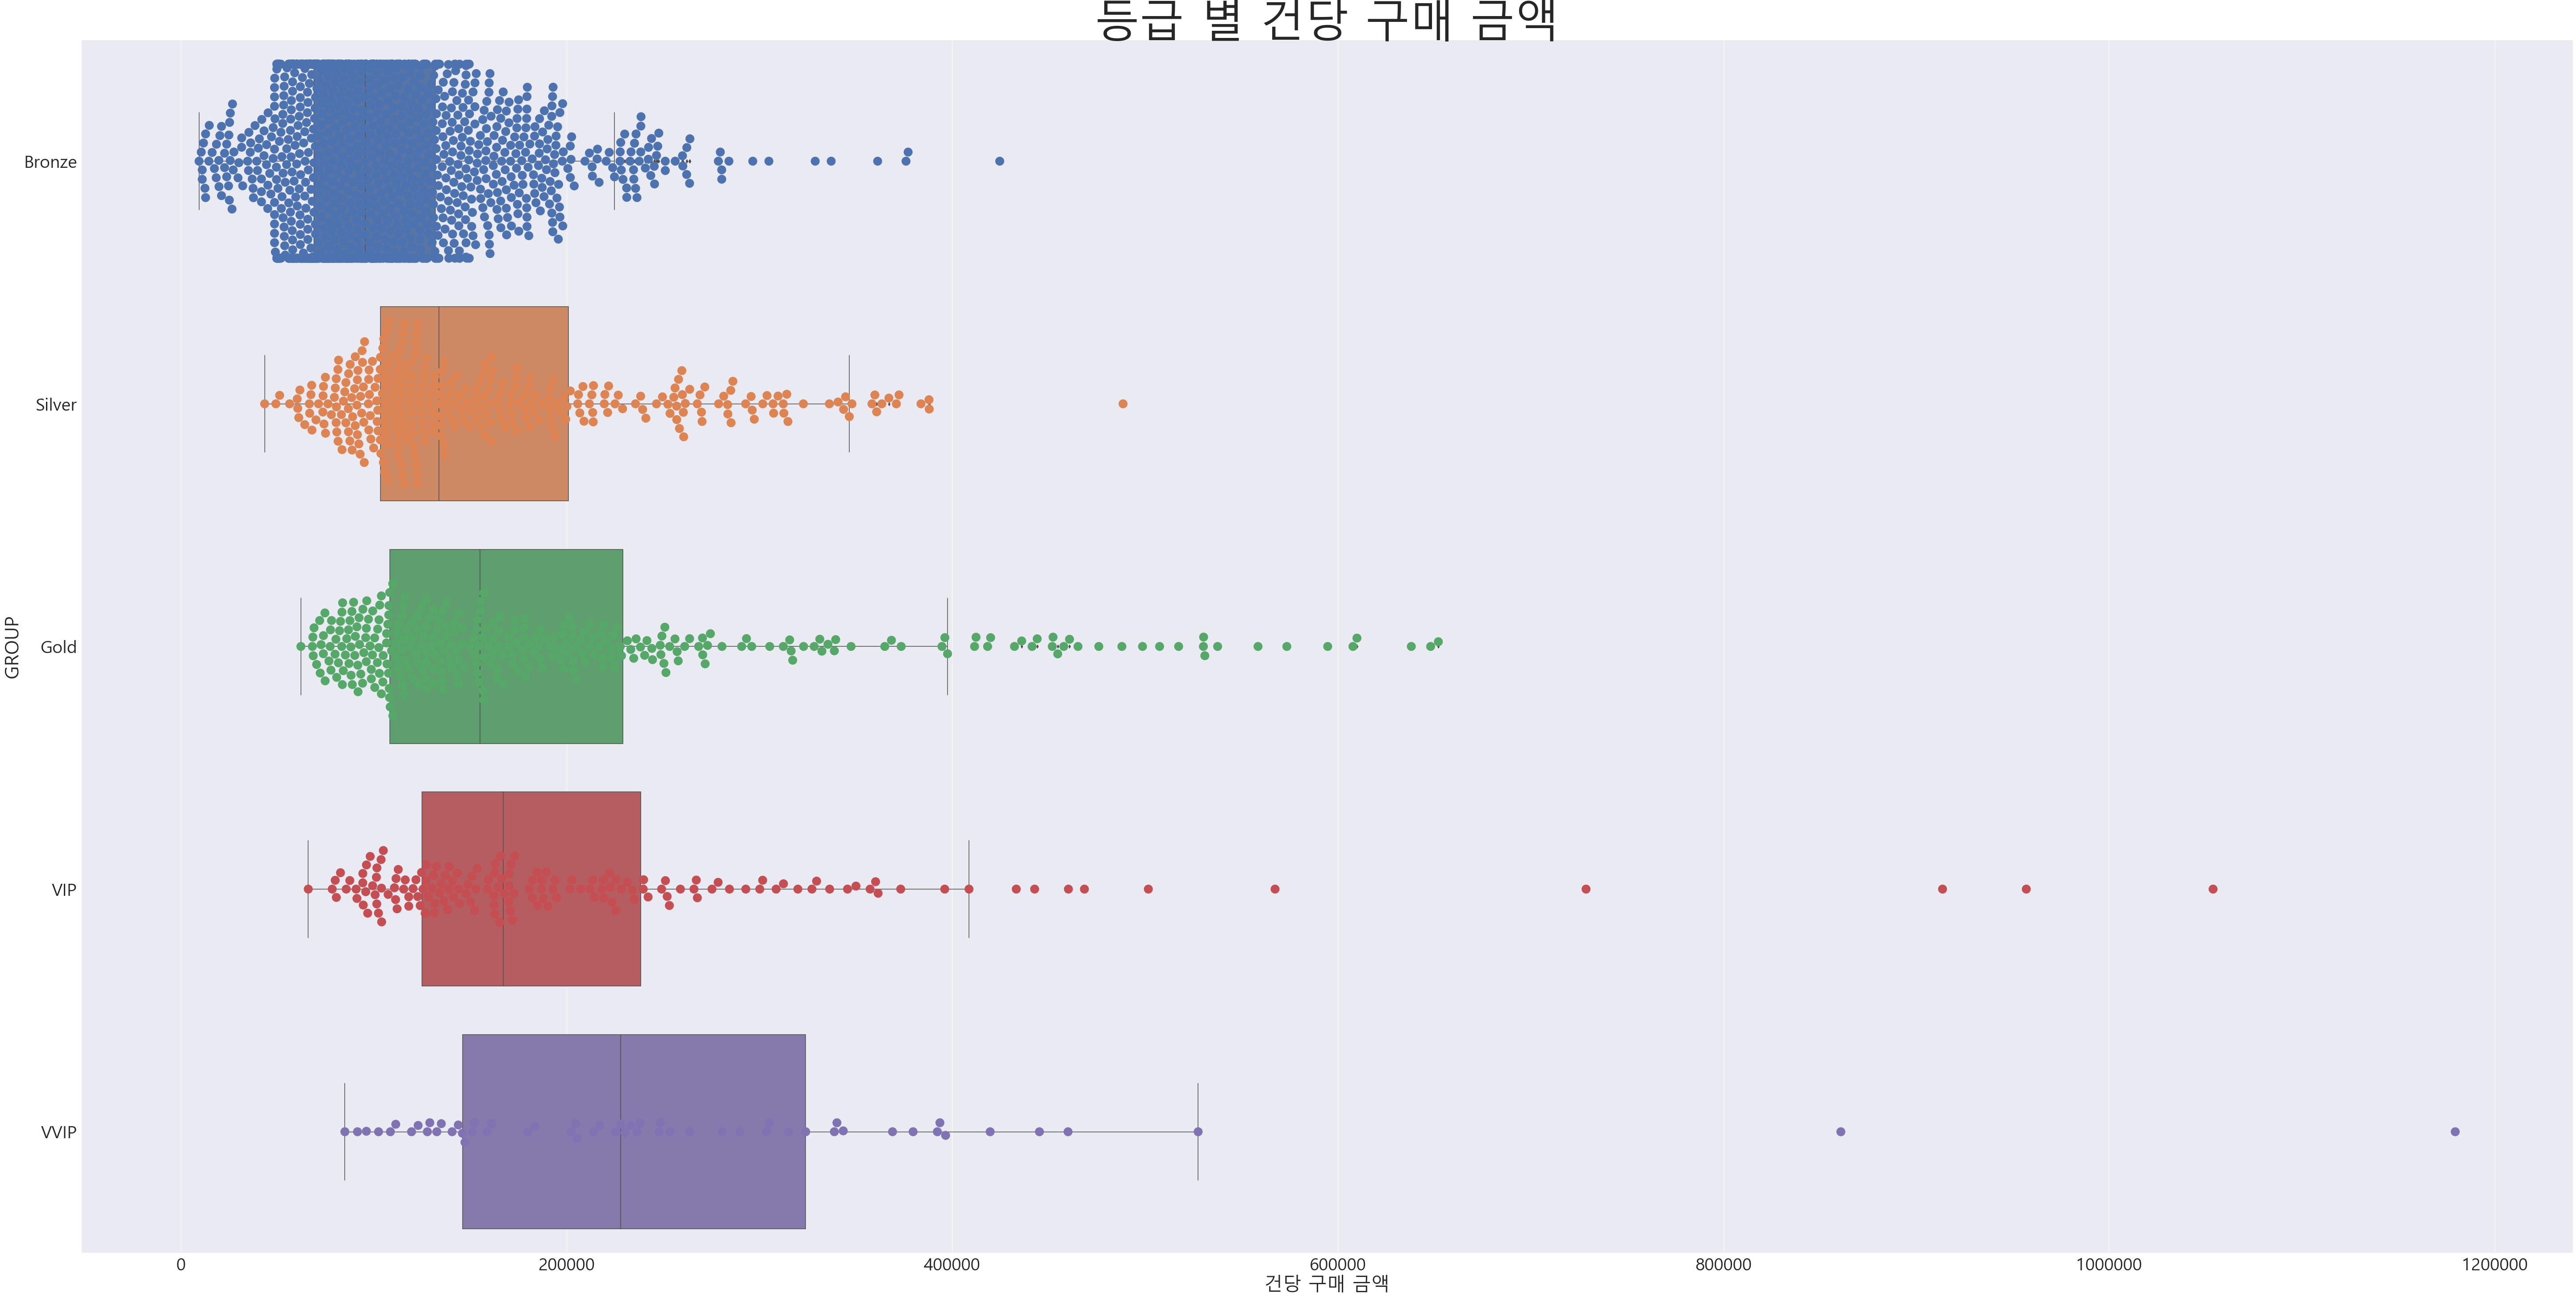

In [79]:
plt.figure(figsize=(100,50))
plt.title('등급 별 건당 구매 금액',size=100)

box = sns.boxplot(x='건당 구매 금액',y='GROUP',order=['Bronze','Silver','Gold','VIP','VVIP'],data=Total)
swarm = sns.swarmplot(x='건당 구매 금액',y='GROUP',order=['Bronze','Silver','Gold','VIP','VVIP'],data=Total,size=20)
plt.show()

### 6) 추천인 아이디

In [82]:
Total.groupby('GROUP').mean()['추천인아이디'].round(2)

GROUP
Bronze    0.02
Gold      0.05
Silver    0.04
VIP       0.06
VVIP      0.16
Name: 추천인아이디, dtype: float64

### 7) 적립금 사용 여부
- 마일리지 혜택 여부와 밀접!

In [83]:
print('Bronze 적립금 사용 경험 O 비율 :', (1-(G1['총 사용 적립금']==0).sum() / len(G1)).round(2))
print('Silver 적립금 사용 경험 O 비율 :', (1-(G2['총 사용 적립금']==0).sum() / len(G2)).round(2))
print('Gold 적립금 사용 경험 O 비율 :', (1-(G3['총 사용 적립금']==0).sum() / len(G3)).round(2))
print('VIP 적립금 사용 경험 O 비율 :', (1-(G4['총 사용 적립금']==0).sum() / len(G4)).round(2))
print('VVIP 적립금 사용 경험 O 비율 :', (1-(G5['총 사용 적립금']==0).sum() / len(G5)).round(2))

Bronze 적립금 사용 경험 O 비율 : 0.16
Silver 적립금 사용 경험 O 비율 : 0.39
Gold 적립금 사용 경험 O 비율 : 0.43
VIP 적립금 사용 경험 O 비율 : 0.64
VVIP 적립금 사용 경험 O 비율 : 0.82
